**EMA Crossover Strategy**

Note : Noise is high

In [105]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime
import time
import requests
import pandas_ta as pta
import numpy as np

In [106]:
def pull_data(symbol, timeframe, _start, _end):
    
    mt5.initialize()

    login = 121391564
    password = 'xxxxxxxx'
    server = 'Exness-MT5Trial7'
    mt5.login(login, password, server)

    raw_df = mt5.copy_rates_range(symbol, timeframe, _start, _end)
    df = pd.DataFrame(raw_df)

    mt5.shutdown()

    df.loc[:,'time'] = pd.to_datetime(df.loc[:,'time'], unit = 's', utc=True)

    return df

In [107]:
def convert_ema_signal(df, period) :
    if 'close' in df.columns:
        df['ema'] = pta.ema(df.loc[:, 'close'], period)
        df['hist'] = df.loc[:, 'close'] - df.loc[:, 'ema']
        df['next_open'] = df.loc[:, 'open'].shift(-1)

        df['signal'] = 'normal'
        mask_buy = (df['hist'] > 0) & (df['hist'].shift(1) < 0)
        mask_sell = (df['hist'] < 0) & (df['hist'].shift(1) > 0)

        df.loc[mask_buy, 'signal'] = 'buy'
        df.loc[mask_sell, 'signal'] = 'sell'

        trade_history = df.loc[df['signal'] != 'normal', :].copy()
        trade_history['profit'] = trade_history['next_open'].diff(1).copy()
        trade_history.loc[trade_history['signal'] == 'buy', 'profit'] = trade_history.loc[trade_history['signal'] == 'buy', 'profit'] * (-1)

        trade_history['profit'].sum()

        return df, trade_history
    else :
        return print("Error, Not found Close")

In [202]:
START_DATE = datetime(2021, 1, 1) #2021-03-19
END_DATE = datetime(2022, 12, 31)
df = pull_data("XAUUSD", mt5.TIMEFRAME_H4, START_DATE, END_DATE)

In [205]:
opm = {}
for ema in np.arange(100, 305, 2):
    opm_df, trade_history_df = convert_ema_signal(df, ema)
    opm[ema] = trade_history_df.profit.sum()

pd.DataFrame(opm.items()).set_index(0).sort_values(1, ascending= False).head()

,1
0,
168,173.336
166,172.528
164,164.254
170,160.789
100,155.158


In [208]:
df_168, trade_history_168 = convert_ema_signal(df, 168)
print(trade_history_168['profit'].min())
print(trade_history_168['profit'].max())

-19.190000000000055
126.981


In [211]:
df_100, trade_history_100 = convert_ema_signal(df, 100)
print(trade_history_100['profit'].min())
print(trade_history_100['profit'].max())

-38.343999999999824
129.24900000000002


<AxesSubplot:>

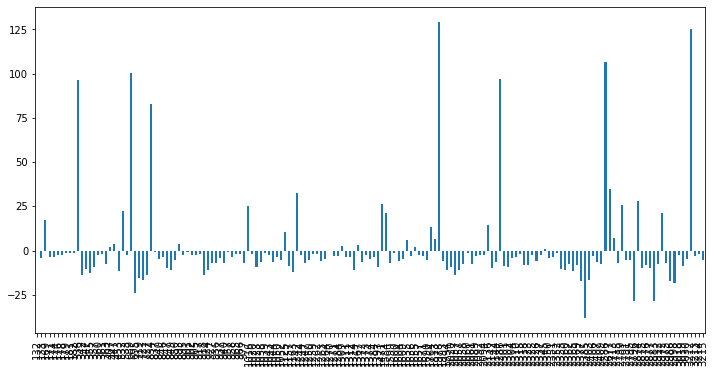

In [210]:
trade_history_100['profit'].plot(kind = 'bar', figsize=(12,6))